In [1]:
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import iterators, optimizers, training, initializers
from chainer.training import extensions
from chainer.cuda import to_cpu

import cv2
import os
import glob
from PIL import Image, ImageOps

import DataAug

In [2]:
class BottleNeckA(chainer.Chain):

    def __init__(self, in_size, ch, out_size, stride=2):
        super(BottleNeckA, self).__init__()
        initialW = initializers.HeNormal()

        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_size, ch, 1, stride, 0, initialW=initialW, nobias=True)
            self.bn1 = L.BatchNormalization(ch)
            self.conv2 = L.Convolution2D(
                ch, ch, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn2 = L.BatchNormalization(ch)
            self.conv3 = L.Convolution2D(
                ch, out_size, 1, 1, 0, initialW=initialW, nobias=True)
            self.bn3 = L.BatchNormalization(out_size)

            self.conv4 = L.Convolution2D(
                in_size, out_size, 1, stride, 0,
                initialW=initialW, nobias=True)
            self.bn4 = L.BatchNormalization(out_size)

    def __call__(self, x):
        h1 = F.relu(self.bn1(self.conv1(x)))
        h1 = F.relu(self.bn2(self.conv2(h1)))
        h1 = self.bn3(self.conv3(h1))
        h2 = self.bn4(self.conv4(x))

        return F.relu(h1 + h2)


class BottleNeckB(chainer.Chain):

    def __init__(self, in_size, ch):
        super(BottleNeckB, self).__init__()
        initialW = initializers.HeNormal()

        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_size, ch, 1, 1, 0, initialW=initialW, nobias=True)
            self.bn1 = L.BatchNormalization(ch)
            self.conv2 = L.Convolution2D(
                ch, ch, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn2 = L.BatchNormalization(ch)
            self.conv3 = L.Convolution2D(
                ch, in_size, 1, 1, 0, initialW=initialW, nobias=True)
            self.bn3 = L.BatchNormalization(in_size)

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = self.bn3(self.conv3(h))

        return F.relu(h + x)


class Block(chainer.ChainList):

    def __init__(self, layer, in_size, ch, out_size, stride=2):
        super(Block, self).__init__()
        self.add_link(BottleNeckA(in_size, ch, out_size, stride))
        for i in range(layer - 1):
            self.add_link(BottleNeckB(out_size, ch))

    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x


class ResNet50(chainer.Chain):

    insize = 224

    def __init__(self, out_n):
        super(ResNet50, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                3, 64, 7, 2, 3, initialW=initializers.HeNormal())
            self.bn1 = L.BatchNormalization(64)
            self.res2 = Block(3, 64, 64, 256, 1)
            self.res3 = Block(4, 256, 128, 512)
            self.res4 = Block(6, 512, 256, 1024)
            self.res5 = Block(3, 1024, 512, 2048)
            self.fc = L.Linear(2048, out_n)

    def __call__(self, x, t=None):
        h = self.bn1(self.conv1(x))
        h = F.max_pooling_2d(F.relu(h), 3, stride=2)
        h = self.res2(h)
        h = self.res3(h)
        h = self.res4(h)
        h = self.res5(h)
        h = F.average_pooling_2d(h, 7, stride=1)
        h = self.fc(h)
        if t is not None:
            loss = F.softmax_cross_entropy(h, t)
            chainer.report({'loss': loss, 'accuracy': F.accuracy(h, t)}, self)
            return loss
        else:
            return to_cpu(F.softmax(h).data)


In [3]:
dataset_dir = "orange_data"
# label_names = os.listdir(dataset_dir)
# label_names = ["778-0", "785-0", "786-0", "130-0"]
label_names = ["785-0", "786-0", "787-0", "788-0"]

In [4]:
_labels = []
_images = []

In [5]:
_labels = []
_images = []
for i, label in enumerate(label_names):
    for f in glob.glob("%s/%s/*"%(dataset_dir,label)):
#         img = Image.open(f).convert('RGB')
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
#         img = ImageOps.grayscale(Image.fromarray(img))
        img = np.array(img.resize((224,224)))
#         img = cv2.GaussianBlur(img, (3, 3), 0)
#         img = cv2.Laplacian(img, cv2.CV_8U, 8)
#         img = cv2.Canny(img, 150, 200, 50)
#         img = cv2.merge((img, img, img))
        _labels.append(i)
        _images.append(img)
        _labels.append(i)
        _images.append(DataAug.affine_image(img))
        _labels.append(i)
        _images.append(DataAug.brightness_image(img))
        _labels.append(i)
        _images.append(DataAug.gray_image(img))
        _labels.append(i)
        _images.append(DataAug.mask_image(img))
        _labels.append(i)
        _images.append(DataAug.small_image(img))
        img2, img3 = DataAug.mirror_image(img)
        _labels.append(i)
        _images.append(img2)
        _labels.append(i)
        _images.append(img3)            

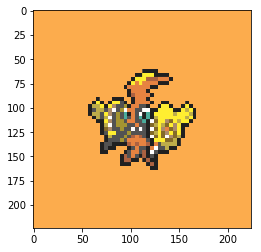

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(_images[0])

In [7]:
# 正規化
# images = np.array(_images, dtype=np.float32) / 255.0
images = np.array(_images, dtype=np.float32)
labels = np.array(_labels, dtype=np.int32)

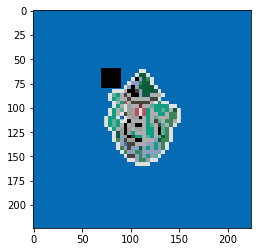

In [8]:
plt.imshow(images[60])

## chainerで扱えるようにRGBの層を手前に持ってくる

In [9]:
images[13].shape

(224, 224, 3)

In [10]:
images = images.transpose(0,3,1,2)

In [11]:
images[0].shape
labels.shape

(224,)

## 画像と正解ラベルのペアを作成する

In [12]:
x_train = chainer.datasets.TupleDataset(images, labels)

## 入力に渡すiteratorの作成

In [13]:
train_iter = iterators.SerialIterator(x_train, batch_size=50, shuffle=True)

## modelの作成

In [14]:
model = ResNet50(out_n=4)

## 最適化手法の選択

In [15]:
optimizer = optimizers.Adam()
optimizer.setup(model)

## undaterとtrainerの作成
device=0で処理が0番GPUに投げられるはず  
訓練結果はresultディレクトリに作成されるはず

In [16]:
updater = training.StandardUpdater(train_iter, optimizer, device=0)

In [17]:
trainer = training.Trainer(updater, (10, 'epoch'), out='result')

## Logの出力設定

In [18]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss']))
trainer.extend(extensions.ProgressBar())

In [19]:
trainer.run()

epoch       main/accuracy  main/loss 
1           0.424          1.96358     
2           0.705          0.619278    
3           0.992          0.0493554   
4           0.985          0.0262395   
5           0.988          0.0144237   
6           0.995          0.0220333   
7           0.996          0.0160789   
8           1              0.00390321  
9           0.996          0.0060657   
10          1              0.00663633  


In [20]:
from chainer import cuda

In [21]:
# img, label = x_train[120]
# plt.imshow(img.transpose(1,2,0))
# # model.train=False
# cuda.check_cuda_available()
# cuda.get_device(0).use()
# xp = cuda.cupy
# # img = Image.open("../YOLOv2/DSC_4.jpg").resize((224,224))
# #         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# # img = ImageOps.grayscale(img)
# # img = np.array(img.resize((224,224)))
# # img = cv2.GaussianBlur(img, (5, 5), 0)
# # #         img = cv2.Laplacian(img, cv2.CV_8U, 8)
# # img = cv2.Canny(img, 150, 200, 50)
# # img = cv2.merge((img, img, img))

# # img = np.array(img, dtype=np.float32) / 255
# # plt.imshow(img)
# # img = img.transpose(2,0,1)
# print("true_label",label)
# print("network's output")
# out = model(xp.asarray(img[None,:]))
# print(out[0,0])
# print(out[0,1])
# print(out[0,2])
# print(out[0,3])

# print(np.argmax(out))

true_label 0
network's output
1.0
0.0
1.24716e-43
0.0
0


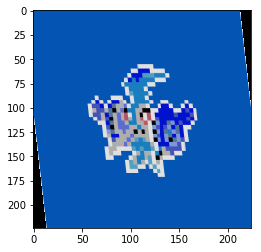

In [38]:
img, label = x_train[1]
plt.imshow(img.transpose(1,2,0))
# model.train=False
with chainer.using_config('train', False):
    cuda.check_cuda_available()
    cuda.get_device(0).use()
    xp = cuda.cupy
#     img = Image.open("../YOLOv2/DSC_1.jpg").resize((224,224))
#     img = np.array(img, dtype=np.float32) / 255
#     img = img.transpose(2,0,1)
    plt.imshow(img.transpose(1,2,0))
    print("true_label",label)
    print("network's output")
    out = model(xp.asarray(img[None,:]))
    print(out[0,0])
    print(out[0,1])
    print(out[0,2])
    print(out[0,3])

    print(np.argmax(out))

In [23]:
label_names = ["778-0", "785-0", "786-0", "130-0"]